## Investigate edge effects in timeshift analysis

We ran into the problem that when we calculate the timeshifted $R^2$ for an epoch, the shifted window might overlap with the boundaries of the epochs - most importantly the go-cue, which can cause huge artifacts in the timeshifted $R^2$.

Here I explore this effect and some ways we try to deal with it.

In [1]:
%load_ext autoreload
%autoreload 2

import os, json
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from mpl_toolkits.mplot3d import axes3d, Axes3D
import scipy.io as spio
from scipy import stats
import pandas as pd
import pickle

import ccf_analysis_utils
import functions as func

In [2]:
def get_single_area_inds(area, df, ccf_labels):
    subregion_labels = func.get_all_subregion_annotations_from_name(df, area)['region'].values
    inds = func.get_neuron_inds_for_subregions(ccf_labels, {area: subregion_labels})
    return inds[area]

In [3]:
match_with_old = False
expanded = True
smallwindows = True
joint = False

In [4]:
figfolder = 'figs/timeshift/'
if match_with_old:
    figfolder += 'match_with_old/'
    if not os.path.exists(figfolder):
        os.makedirs(figfolder)

In [5]:
df = pd.read_excel('mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx',engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)

r2_new = pickle.load(open('r2_data_dict_timeshifts.pkl', 'rb'))
if match_with_old:
    r2_new = pickle.load(open('r2_data_dict_match_with_old_timeshifts.pkl', 'rb'))
if expanded:
    #r2_new = pickle.load(open('r2_data_dict_expanded.pkl', 'rb'))
    r2_new = pickle.load(open('r2_data_dict_expanded_smallwindow.pkl', 'rb'))
if smallwindows:
    #r2_smallwin = pickle.load(open('r2_data_dict_smallwindows.pkl', 'rb'))
    r2_smallwin = pickle.load(open('r2_data_dict_smallwindows_v3.pkl', 'rb'))
if joint:
    r2_new = pickle.load(open('r2_data_dict_joint.pkl', 'rb'))
ccf_labels = r2_new['5_0']['ccf_labels'].copy()
is_alm = r2_new['5_0']['is_alm'].copy()

alm_inds = np.where(is_alm)[0]

alm_inds_smallwin = np.where(r2_smallwin['5_0']['is_alm'])[0]
ccf_labels_smallwin = r2_smallwin['5_0']['ccf_labels'].copy()
areas = ['Medulla','Midbrain','ALM', 'Striatum', 'Thalamus',]

epochs = ['sample','delay','response']
r2_methods = ['old', 'old_clipped', 'new']

method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}

In [6]:
timeshifts = [-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16]
if match_with_old:
    timeshifts = [-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30]
if expanded or smallwindows or joint:
    timeshifts = np.arange(-30,32,2, dtype = int)
timeshifts = np.array(timeshifts)

In [7]:
r2_new['5_0'].keys()

dict_keys(['sample_r2', 'delay_r2', 'response_r2', 'sample_r2_old', 'delay_r2_old', 'response_r2_old', 'session_name', 'ccf_coords', 'ccf_labels', 'sample_fr', 'delay_fr', 'response_fr', 'is_alm', 'avg_fr', 'mean_corr_fr', 'trial_to_trial_var', 'sample_r2_shifted', 'delay_r2_shifted', 'response_r2_shifted', 'sample_r2_shifted_old', 'delay_r2_shifted_old', 'response_r2_shifted_old'])

In [8]:
timewindow_cuts = ['no_cut', 'shift_by_dt', 'fixed_small']
twcuts_to_string = {'no_cut': '', 'shift_by_dt': '_shifted', 'fixed_small': ''}

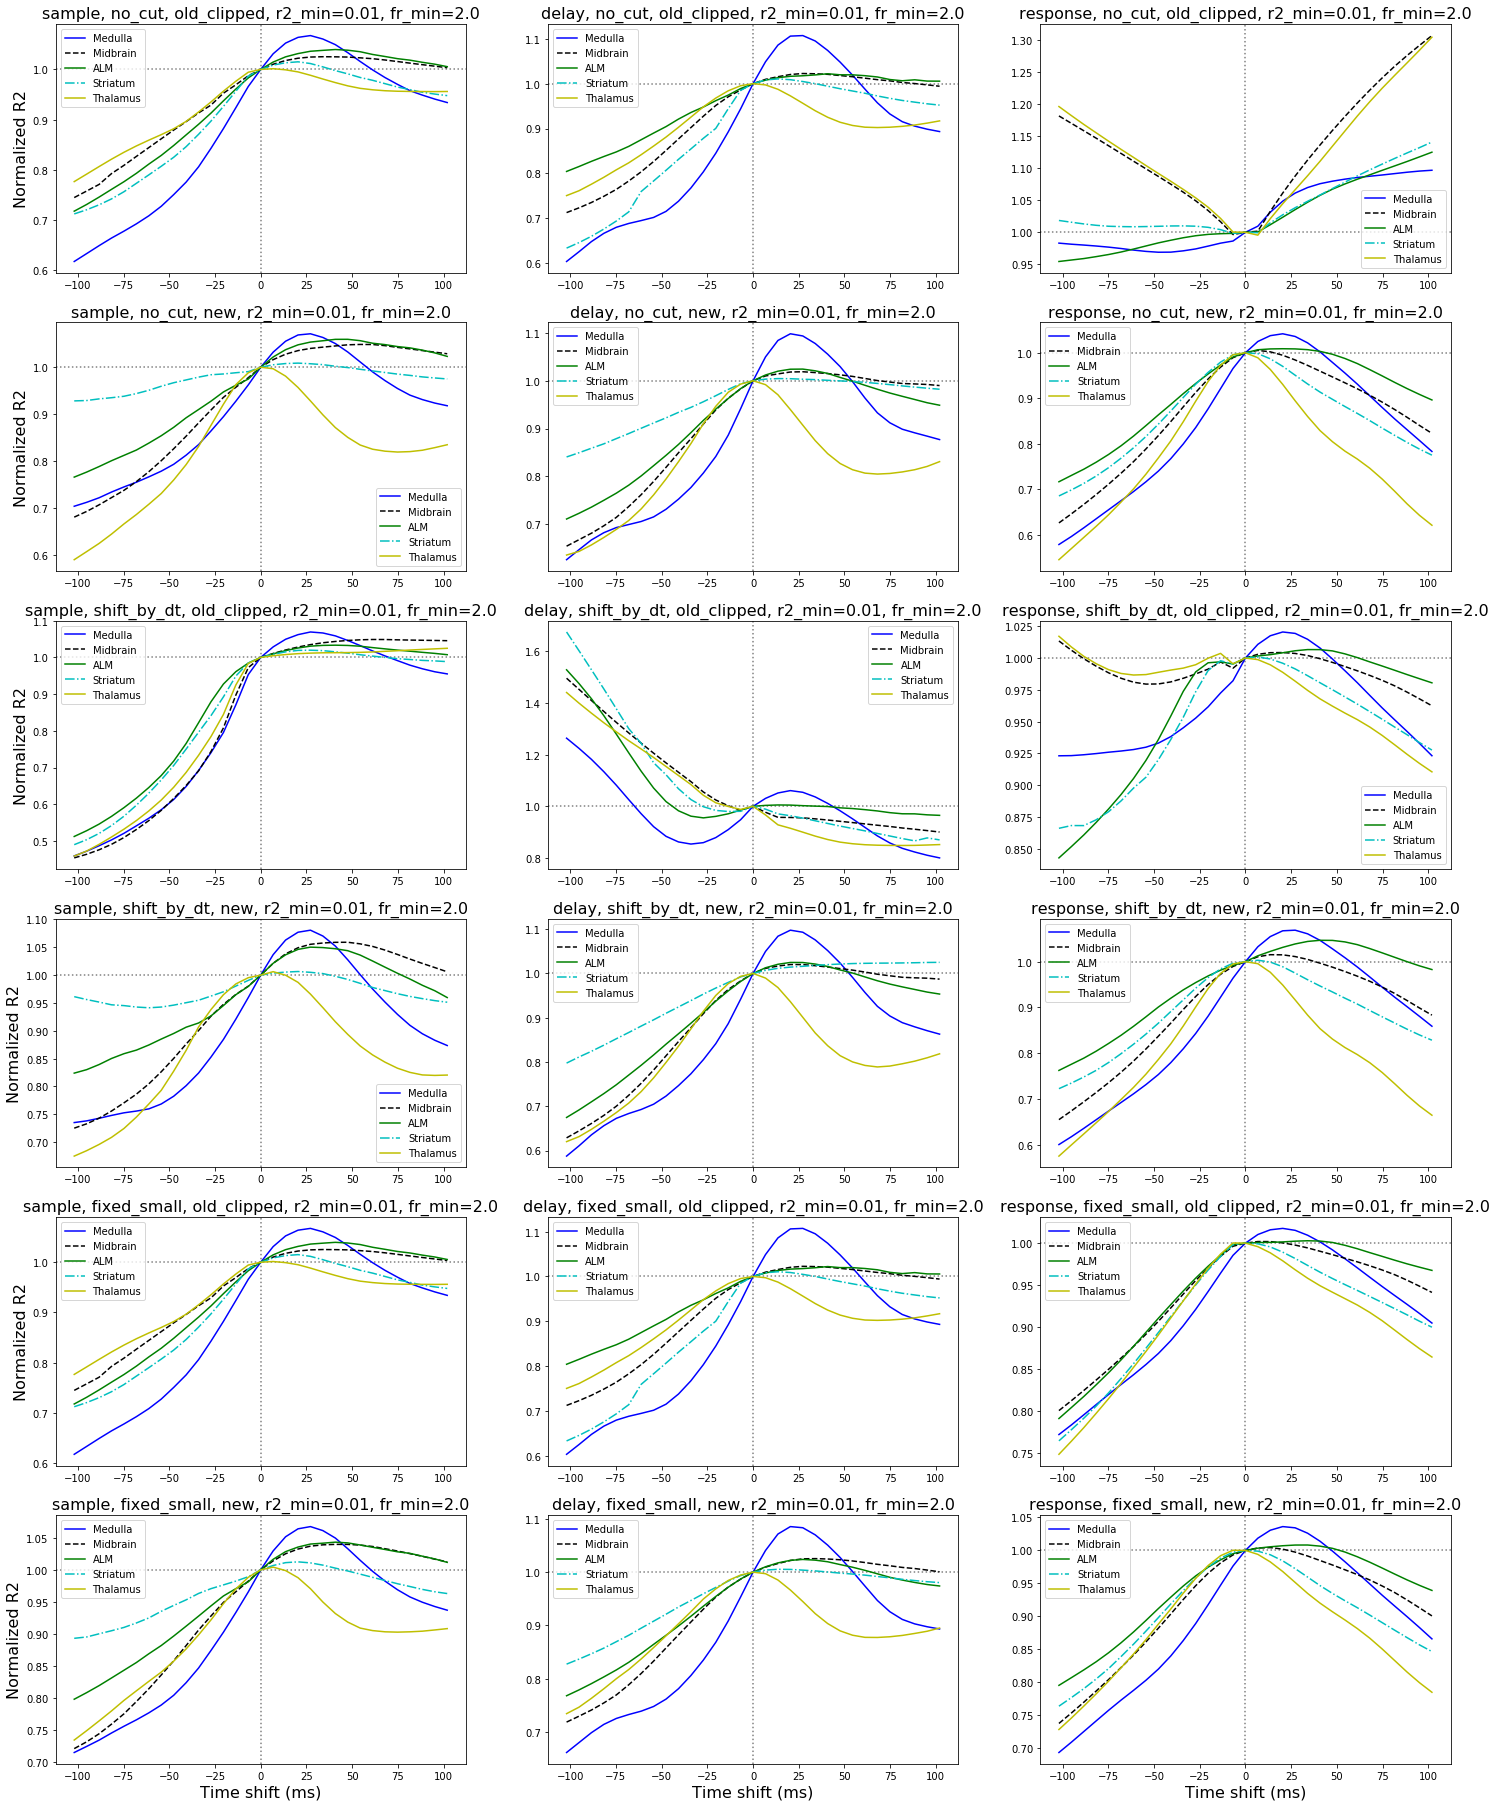

In [9]:
plt.subplots(6,3, figsize = (25,32))

lines_colors = ['b-', 'k--', 'g-', 'c-.', 'y-']

r2_threshold = .01
fr_threshold = 2.


for itw, timewindow_cut in enumerate(timewindow_cuts):
    for ir2m, r2_method in enumerate(['old_clipped', 'new']):
        for iepoch, epoch in enumerate(epochs):

            r2 = []

            if itw < 2:
                fr = r2_new['5_0']['avg_fr'].copy()

                for timesh in timeshifts:
                    r2.append(r2_new['5_%d'%timesh]['%s_r2%s%s'%(epoch,twcuts_to_string[timewindow_cut],method_to_string[r2_method])].copy())

                r2= np.array(r2)
                r2[r2<0] = 0

                fr_inds = np.where(fr > fr_threshold)[0]
                threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
                threshold_inds = np.intersect1d(threshold_inds, fr_inds)


                
            elif itw == 2:
                fr = r2_smallwin['5_0']['avg_fr'].copy()

                for timesh in timeshifts:
                    r2.append(r2_smallwin['5_%d'%timesh]['%s_r2%s%s'%(epoch,twcuts_to_string[timewindow_cut],method_to_string[r2_method])].copy())

                r2= np.array(r2)
                r2[r2<0] = 0

                fr_inds = np.where(fr > fr_threshold)[0]
                threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
                threshold_inds = np.intersect1d(threshold_inds, fr_inds)
            
            plt.subplot(6,3,6*itw + 3* ir2m + iepoch+1)
            plt.title('%s, %s, %s, r2_min=%.2f, fr_min=%.1f'%(epoch,timewindow_cut,r2_method,r2_threshold,fr_threshold), fontsize = 16)
            for j, area in enumerate(areas):
                if area == 'ALM':
                    inds = alm_inds
                    if itw == 2:
                        inds = alm_inds_smallwin
                else:
                    inds = get_single_area_inds(area, df, ccf_labels)
                    if itw == 2:
                        inds = get_single_area_inds(area, df, ccf_labels_smallwin)

                inds = np.intersect1d(inds, threshold_inds)
                avg_r2 = r2[:,inds].mean(axis = 1)

                plt.plot(timeshifts*3.4, avg_r2/avg_r2[np.where(timeshifts == 0)[0][0]],lines_colors[j], label = area)



            a,b = plt.xlim()
            plt.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
            plt.xlim(a,b)

            a,b = plt.ylim()
            plt.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
            plt.ylim(a,b)

            if itw == 2 and ir2m == 1: plt.xlabel('Time shift (ms)', fontsize = 16)
            if iepoch == 0: plt.ylabel('Normalized R2', fontsize = 16)
            plt.legend()

#plt.savefig(figfolder + 'comparison_of_r2_and_timewindow_methods_r2_fr_threshold.pdf', bbox_inches = 'tight')

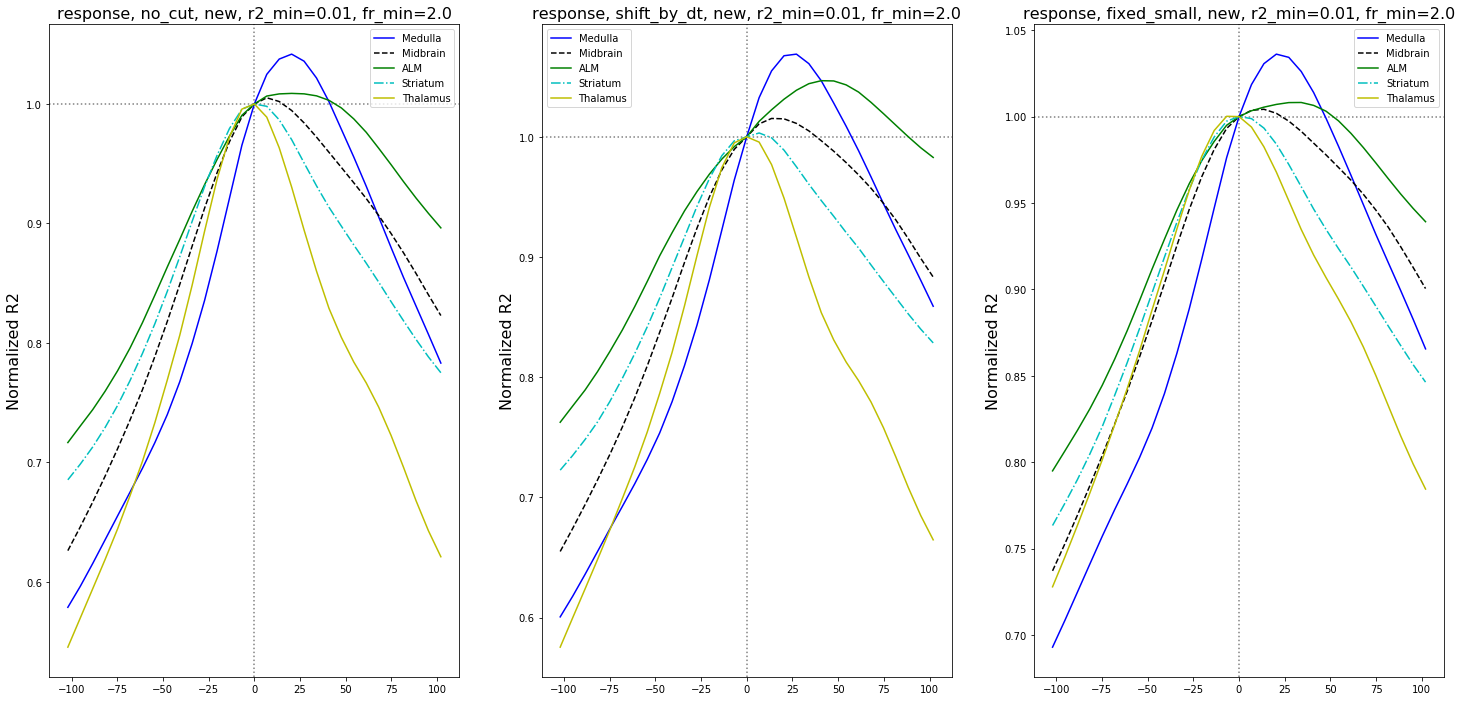

In [10]:
plt.subplots(1,3, figsize = (25,12))

lines_colors = ['b-', 'k--', 'g-', 'c-.', 'y-']

r2_threshold = .01
fr_threshold = 2.


for itw, timewindow_cut in enumerate(timewindow_cuts):
    for ir2m, r2_method in enumerate(['new']):
        for iepoch, epoch in enumerate(['response']):

            r2 = []

            if itw < 2:
                fr = r2_new['5_0']['avg_fr'].copy()

                for timesh in timeshifts:
                    r2.append(r2_new['5_%d'%timesh]['%s_r2%s%s'%(epoch,twcuts_to_string[timewindow_cut],method_to_string[r2_method])].copy())

                r2= np.array(r2)
                r2[r2<0] = 0

                fr_inds = np.where(fr > fr_threshold)[0]
                threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
                threshold_inds = np.intersect1d(threshold_inds, fr_inds)


                
            elif itw == 2:
                fr = r2_smallwin['5_0']['avg_fr'].copy()

                for timesh in timeshifts:
                    r2.append(r2_smallwin['5_%d'%timesh]['%s_r2%s%s'%(epoch,twcuts_to_string[timewindow_cut],method_to_string[r2_method])].copy())

                r2= np.array(r2)
                r2[r2<0] = 0

                fr_inds = np.where(fr > fr_threshold)[0]
                threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
                threshold_inds = np.intersect1d(threshold_inds, fr_inds)
            
            plt.subplot(1,3,itw + 1)
            plt.title('%s, %s, %s, r2_min=%.2f, fr_min=%.1f'%(epoch,timewindow_cut,r2_method,r2_threshold,fr_threshold), fontsize = 16)
            for j, area in enumerate(areas):
                if area == 'ALM':
                    inds = alm_inds
                    if itw == 2:
                        inds = alm_inds_smallwin
                else:
                    inds = get_single_area_inds(area, df, ccf_labels)
                    if itw == 2:
                        inds = get_single_area_inds(area, df, ccf_labels_smallwin)

                inds = np.intersect1d(inds, threshold_inds)
                avg_r2 = r2[:,inds].mean(axis = 1)

                plt.plot(timeshifts*3.4, avg_r2/avg_r2[np.where(timeshifts == 0)[0][0]],lines_colors[j], label = area)



            a,b = plt.xlim()
            plt.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
            plt.xlim(a,b)

            a,b = plt.ylim()
            plt.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
            plt.ylim(a,b)

            if itw == 2 and ir2m == 1: plt.xlabel('Time shift (ms)', fontsize = 16)
            if iepoch == 0: plt.ylabel('Normalized R2', fontsize = 16)
            plt.legend()

#plt.savefig(figfolder + 'comparison_of_r2_and_timewindow_methods_r2_fr_threshold.pdf', bbox_inches = 'tight')

# Focus on the new method with small windows

As taking the avg of the per-timepoint $R^2$ seems to be robust against the various timewindow cuts I will just go along with that, and also take smallest common timewindow for epoch averaging.

In [11]:
r2_threshold = .01
fr_threshold = 2.

epoch = 'response'
r2_method = 'new'
timewindow_cut = 'fixed_small'

fr = r2_smallwin['5_0']['avg_fr'].copy()
r2 = []

for timesh in timeshifts:
    r2.append(r2_smallwin['5_%d'%timesh]['%s_r2%s%s'%(epoch,twcuts_to_string[timewindow_cut],method_to_string[r2_method])].copy())

r2 = np.array(r2)
# there are no negative values in the new method
#r2[r2<0] = 0

fr_inds = np.where(fr > fr_threshold)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)

best_times = 3.4 * timeshifts[r2.argmax(axis = 0)]
area_colors = ['b', 'k', 'g', 'c', 'y']
k = 4

k_r2_diff = r2[np.where(timeshifts == k)[0][0],:] - r2[np.where(timeshifts == -k)[0][0],:]

area_inds = {}
for j, area in enumerate(areas):
    if area == 'ALM':
        inds = alm_inds_smallwin
    else:
        inds = get_single_area_inds(area, df, ccf_labels_smallwin)

    inds = np.intersect1d(inds, threshold_inds)
    area_inds[area] = inds

In [12]:
best_times = 3.4 * timeshifts[r2.argmax(axis = 0)]
area_colors = ['b', 'k', 'g', 'c', 'y']
k = 4

k_r2_diff = r2[np.where(timeshifts == k)[0][0],:] - r2[np.where(timeshifts == -k)[0][0],:]

In [13]:
area_inds = {}
for j, area in enumerate(areas):
    if area == 'ALM':
        inds = alm_inds_smallwin
    else:
        inds = get_single_area_inds(area, df, ccf_labels_smallwin)

    inds = np.intersect1d(inds, threshold_inds)
    area_inds[area] = inds

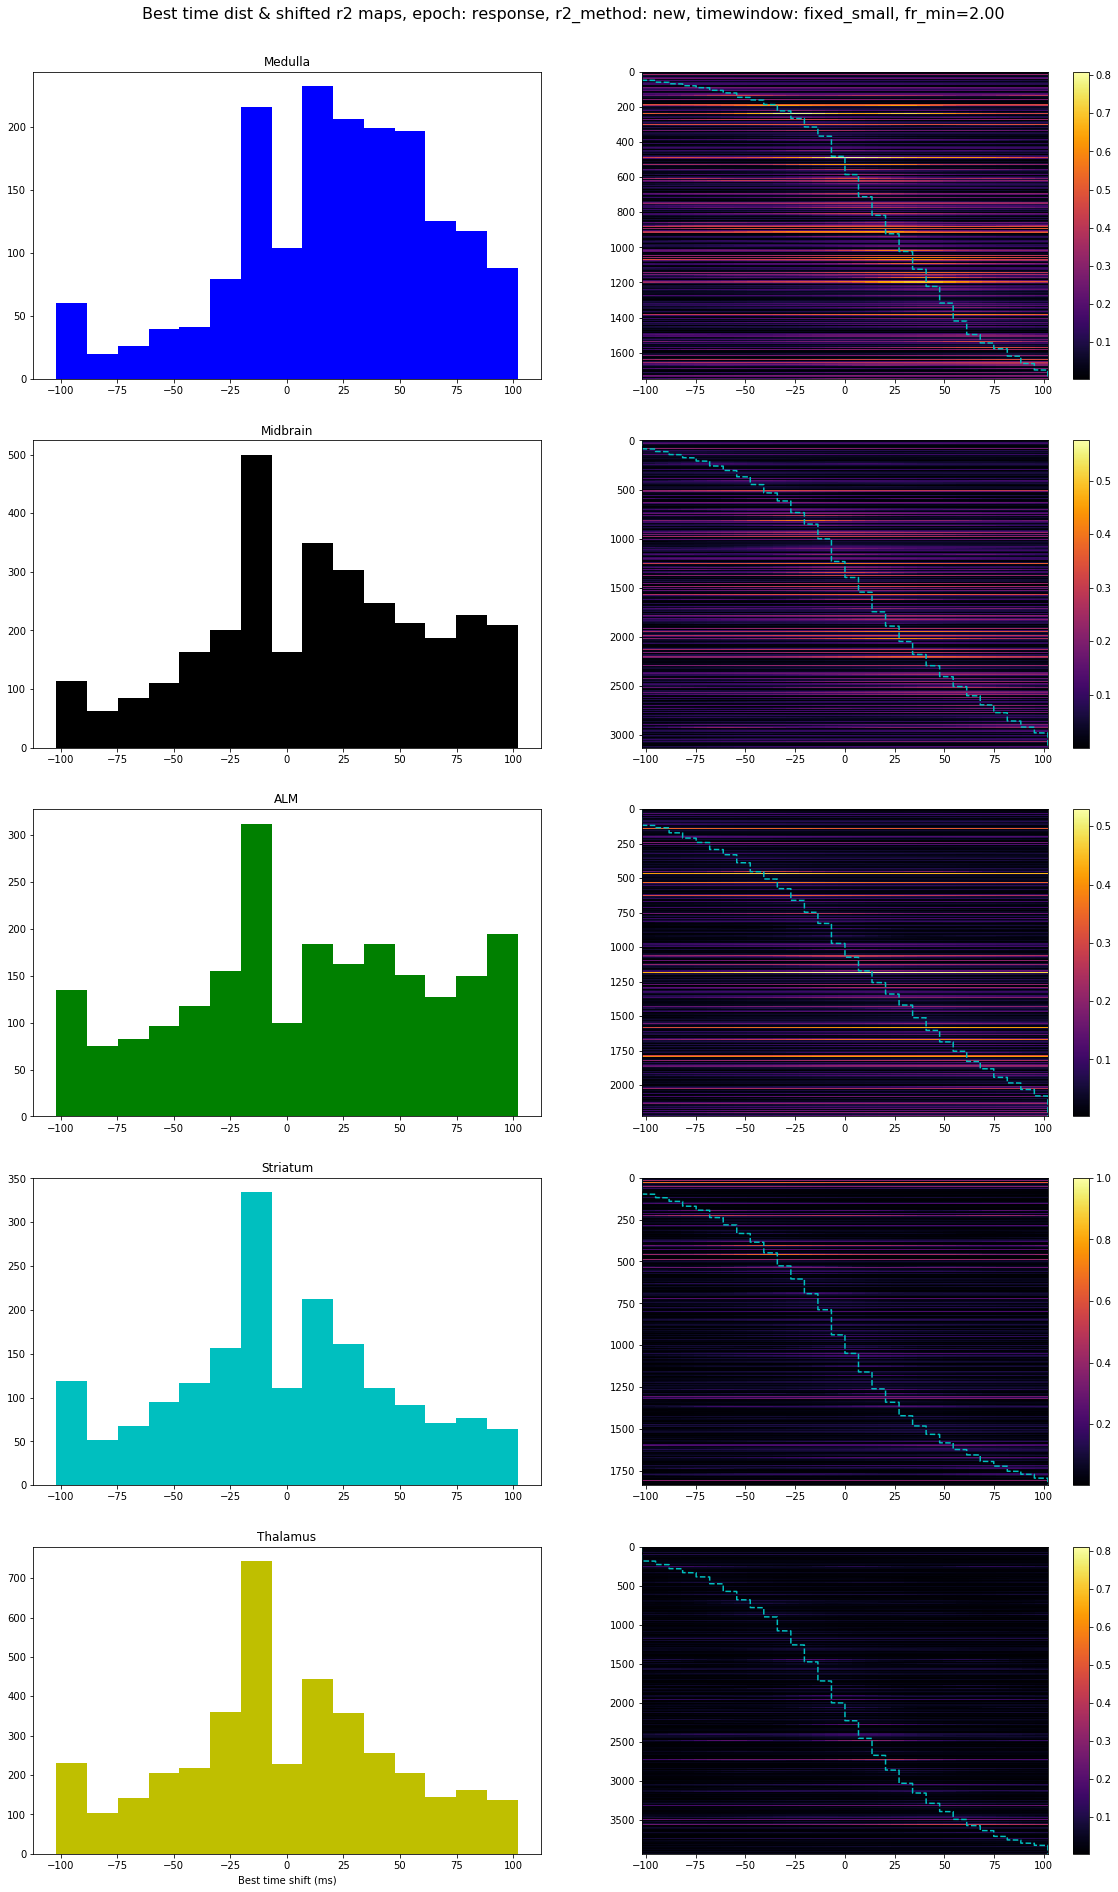

In [14]:
f,_ = plt.subplots(5,2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, timewindow: %s, fr_min=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold), fontsize = 16)
for i, area in enumerate(areas):
    plt.subplot(5,2,2*i+1)
    plt.hist(best_times[area_inds[area]], bins = 15, color = area_colors[i])
    plt.title(area)
    if i == 4: plt.xlabel('Best time shift (ms)')

    plt.subplot(5,2,2*i+2)
    _area_shifted_r2 = r2[:,area_inds[area]]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)

    plt.imshow(_area_shifted_r2[:,_area_sortinds].T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)

In [15]:
delta_r2 = 0.5

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

<ipython-input-15-1bcf75953af4>:3: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


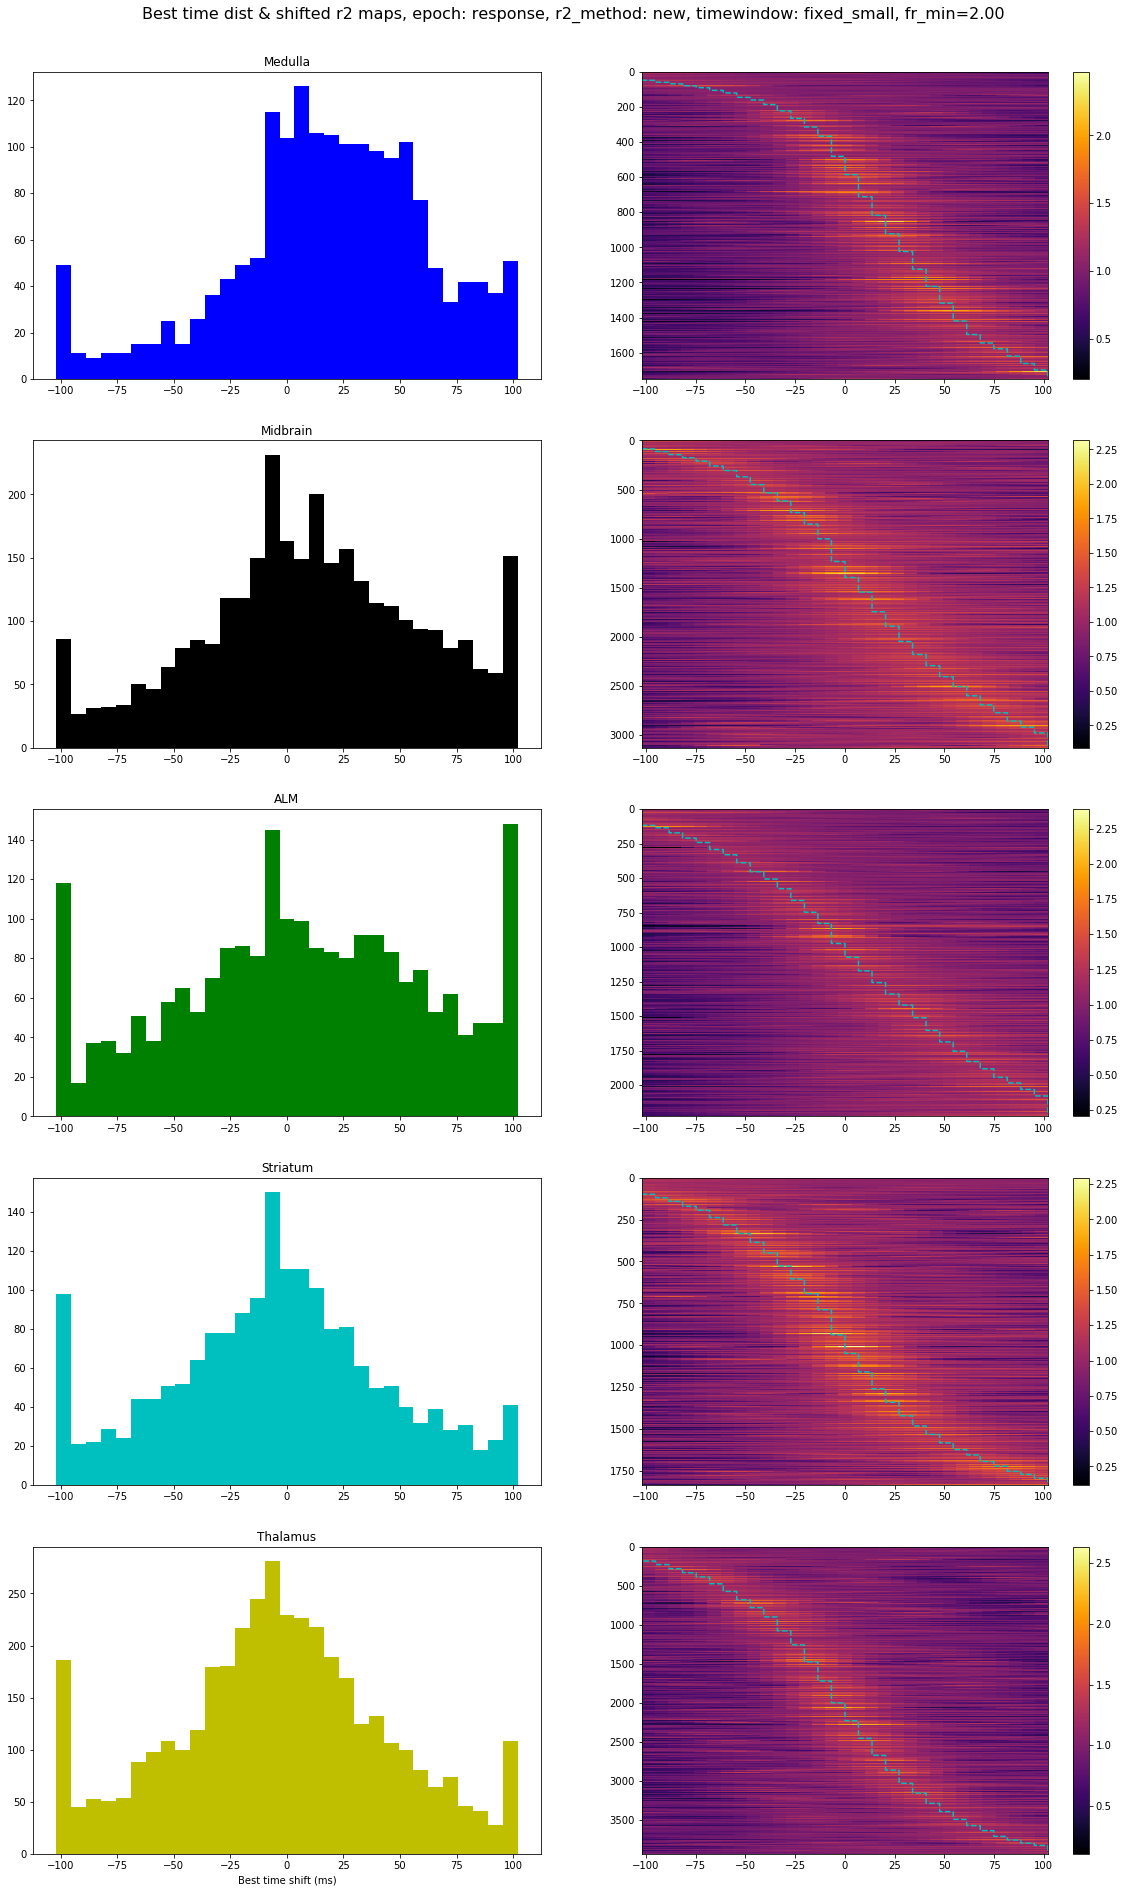

In [16]:
f,_ = plt.subplots(5,2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, timewindow: %s, fr_min=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold), fontsize = 16)
for i, area in enumerate(areas):
    _this_inds = np.intersect1d(area_inds[area], delta_inds)
    plt.subplot(5,2,2*i+1)
    plt.hist(best_times[_this_inds], bins = 31, color = area_colors[i])
    plt.title(area)
    if i == 4: plt.xlabel('Best time shift (ms)')

    plt.subplot(5,2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)

In [17]:
delta_r2 = 0.5
delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

<ipython-input-17-ce09138f6090>:2: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


In [75]:
area_histograms = np.zeros((len(areas), 40, 31))
for idelta, delta in enumerate(np.linspace(1.,1.5,40)):
    delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta)[0]
    for i, area in enumerate(areas):
        _this_inds = np.intersect1d(area_inds[area], delta_inds)

        n,_ = np.histogram(best_times[_this_inds], bins = 31)
        area_histograms[i,idelta] = n



<ipython-input-75-6cf6baf1f642>:3: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta)[0]


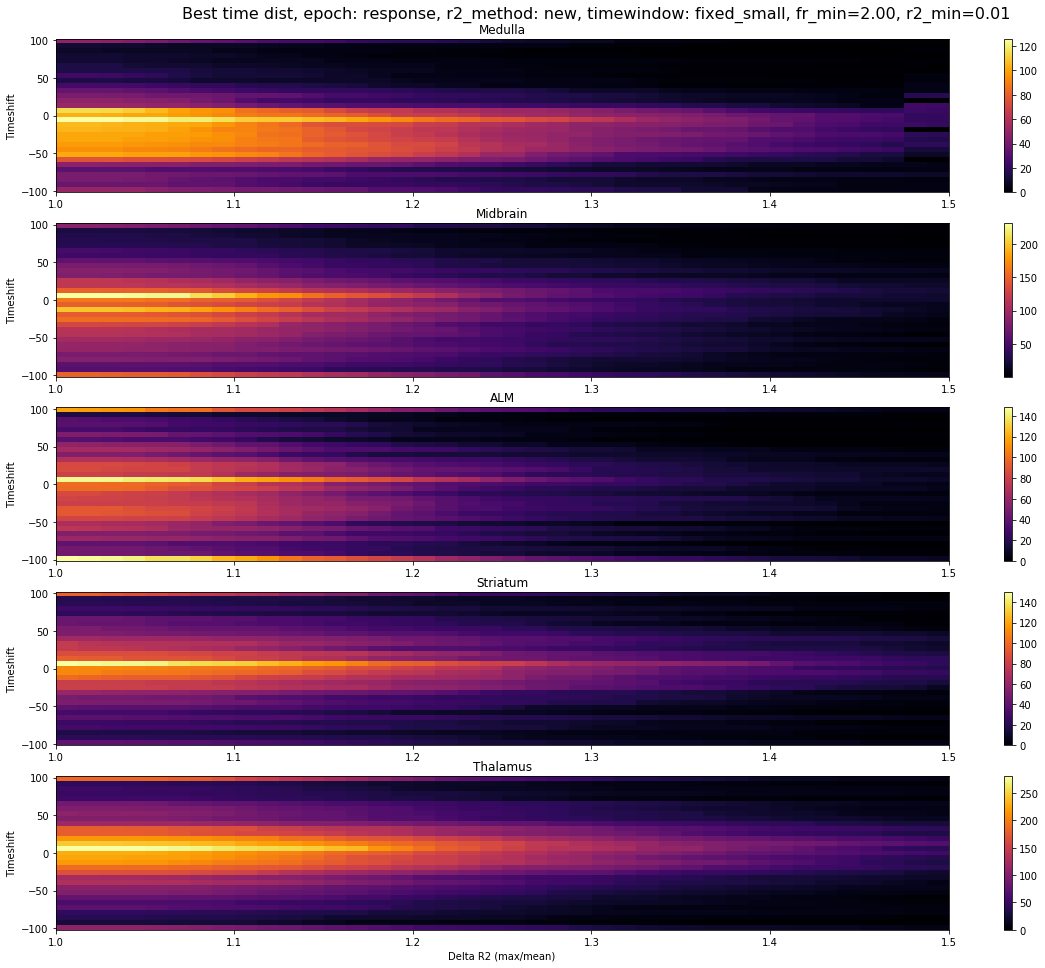

In [76]:
f,_ = plt.subplots(5,1, figsize = (20,15))
f.suptitle('Best time dist, epoch: %s, r2_method: %s, timewindow: %s, fr_min=%.2f, r2_min=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold,r2_threshold), fontsize = 16)

for i, area in enumerate(areas):
    plt.subplot(5,1,i+1)
    plt.imshow(area_histograms[i,:,:].T, aspect='auto', cmap = 'inferno', extent=[1,1.5, -102, 102])
    plt.title(area)
    plt.colorbar()
    plt.ylabel('Timeshift')
    if i == 4: plt.xlabel('Delta R2 (max/mean)')

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'max_over_avg_filtering_scan_area_histograms.pdf', bbox_inches = 'tight')

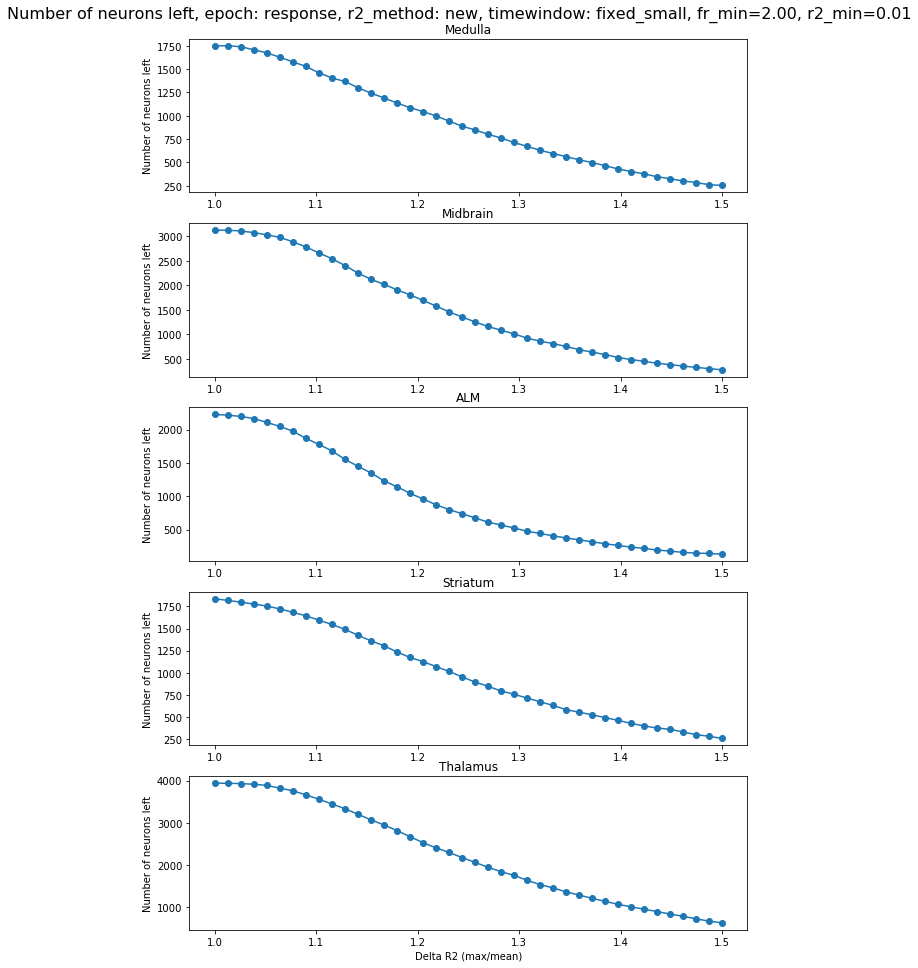

In [77]:
f,_ = plt.subplots(5,1, figsize = (10,15))
f.suptitle('Number of neurons left, epoch: %s, r2_method: %s, timewindow: %s, fr_min=%.2f, r2_min=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold,r2_threshold), fontsize = 16)

for i, area in enumerate(areas):
    plt.subplot(5,1,i+1)
    plt.plot(np.linspace(1,1.5,40),area_histograms[i,:,:].sum(axis = 1), 'o-')
    plt.title(area)
    plt.ylabel('Number of neurons left')
    if i == 4: plt.xlabel('Delta R2 (max/mean)')

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'max_over_avg_filtering_scan_number_of_neurons_left.pdf', bbox_inches = 'tight')

<ipython-input-21-2b09b8910c01>:3: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


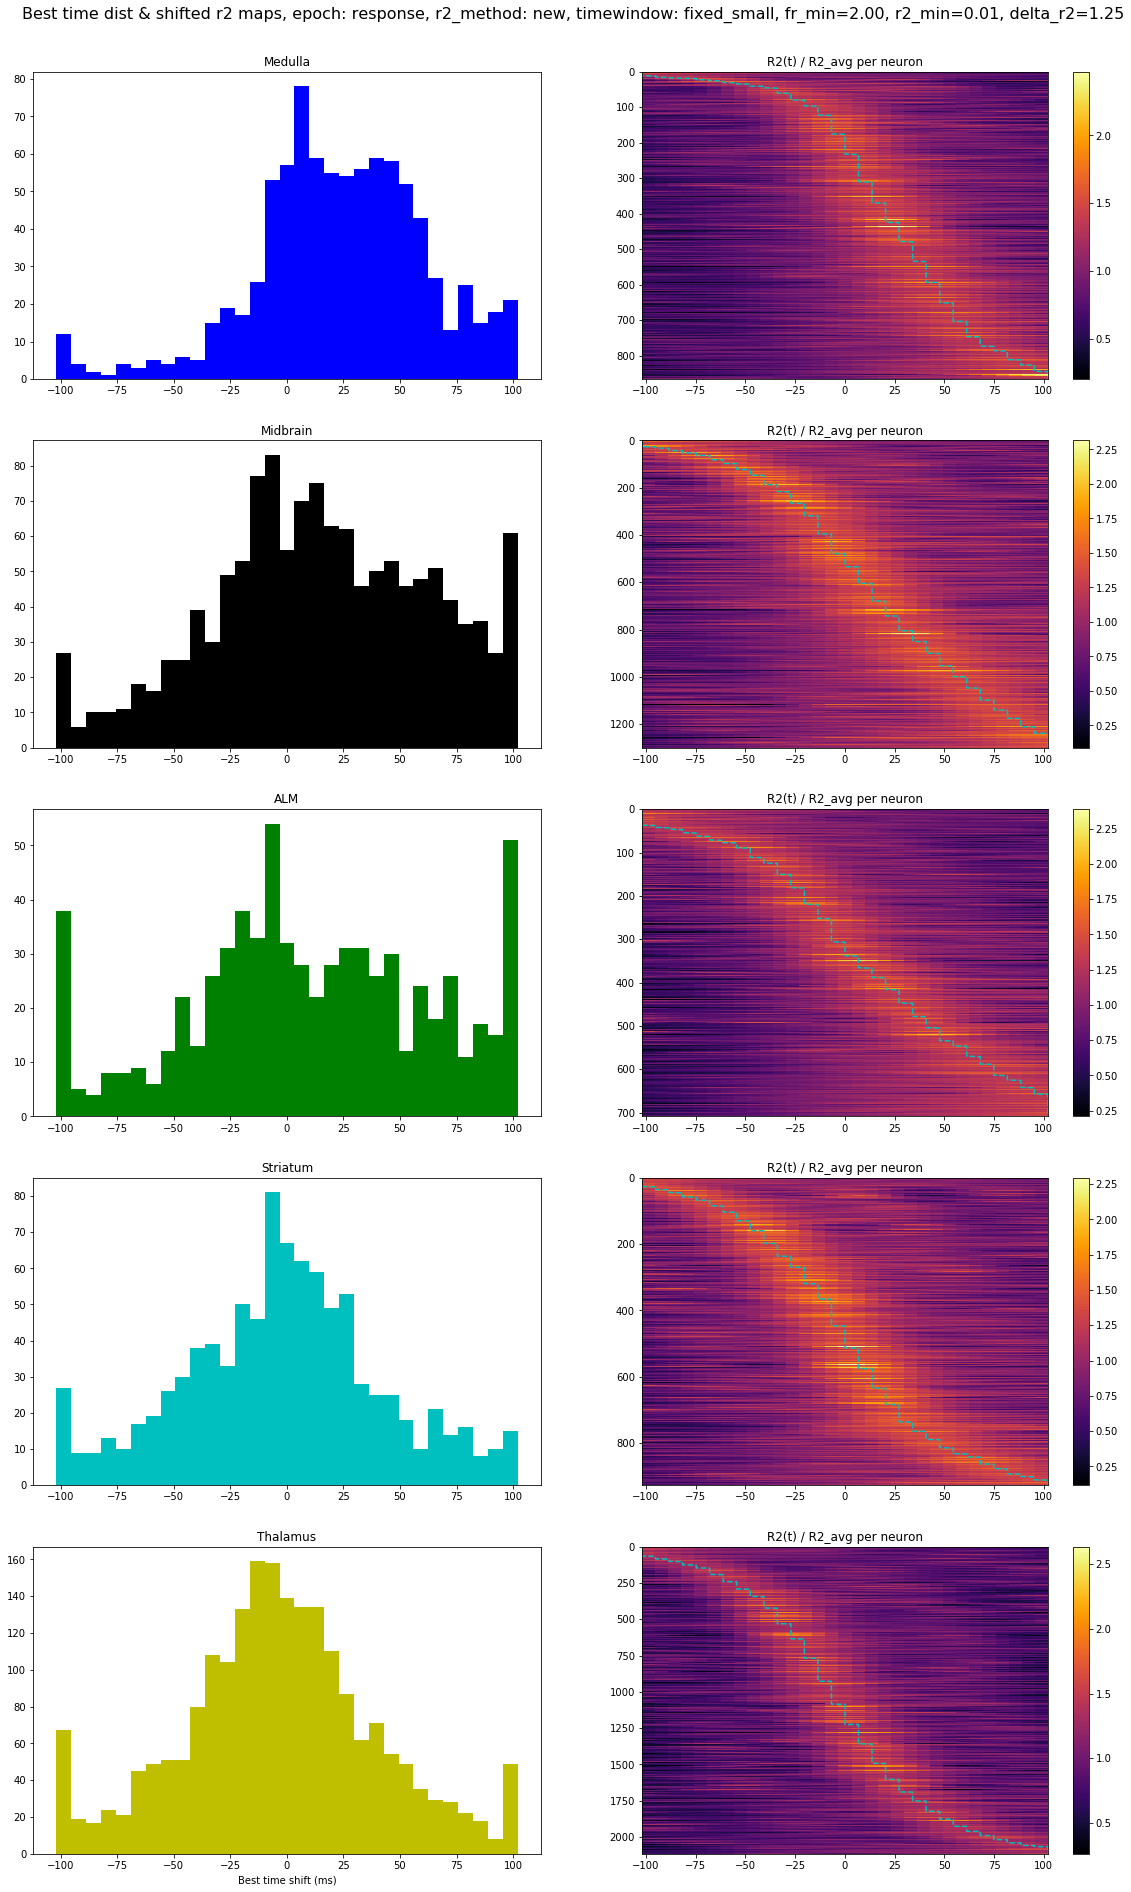

In [21]:
delta_r2 = 1.25

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(5,2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, timewindow: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(areas):
    _this_inds = np.intersect1d(area_inds[area], delta_inds)
    plt.subplot(5,2,2*i+1)
    plt.hist(best_times[_this_inds], bins = 31, color = area_colors[i])
    plt.title(area)
    if i == 4: plt.xlabel('Best time shift (ms)')

    plt.subplot(5,2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
plt.savefig(figfolder + 'max_over_avg_filtering_scan_best_time_dist_and_r2_maps.pdf', bbox_inches = 'tight')

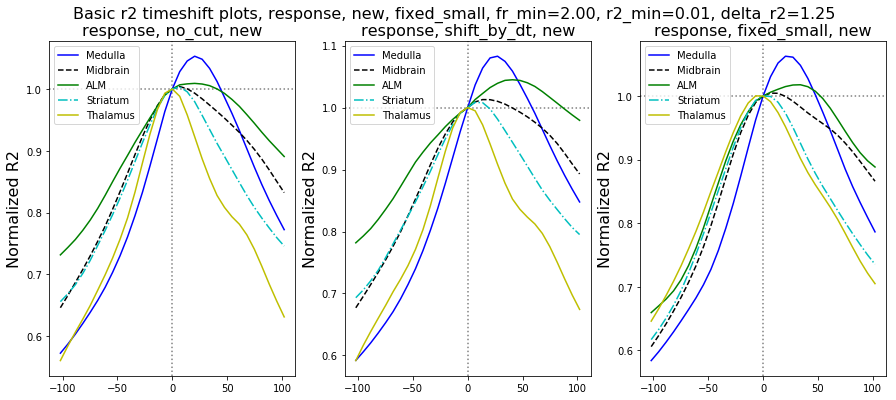

In [22]:

lines_colors = ['b-', 'k--', 'g-', 'c-.', 'y-']

r2_threshold = .01
fr_threshold = 2.

f, _ = plt.subplots(1,3, figsize = (15,6))
f.suptitle('Basic r2 timeshift plots, %s, %s, %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold,r2_threshold,delta_r2), fontsize = 16)


for itw, timewindow_cut in enumerate(timewindow_cuts):
    for ir2m, r2_method in enumerate(['new']):
        for iepoch, epoch in enumerate(['response']):

            r2 = []

            if itw < 2:
                fr = r2_new['5_0']['avg_fr'].copy()

                for timesh in timeshifts:
                    r2.append(r2_new['5_%d'%timesh]['%s_r2%s%s'%(epoch,twcuts_to_string[timewindow_cut],method_to_string[r2_method])].copy())

                r2= np.array(r2)
                r2[r2<0] = 0

                fr_inds = np.where(fr > fr_threshold)[0]
                threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
                threshold_inds = np.intersect1d(threshold_inds, fr_inds)


                
            elif itw == 2:
                fr = r2_smallwin['5_0']['avg_fr'].copy()

                for timesh in timeshifts:
                    r2.append(r2_smallwin['5_%d'%timesh]['%s_r2%s%s'%(epoch,twcuts_to_string[timewindow_cut],method_to_string[r2_method])].copy())

                r2= np.array(r2)
                r2[r2<0] = 0

                fr_inds = np.where(fr > fr_threshold)[0]
                threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
                threshold_inds = np.intersect1d(threshold_inds, fr_inds)
            
            plt.subplot(1,3,itw + 1)
            plt.title('%s, %s, %s'%(epoch,timewindow_cut,r2_method), fontsize = 16)
            for j, area in enumerate(areas):
                if area == 'ALM':
                    inds = alm_inds
                    if itw == 2:
                        inds = alm_inds_smallwin
                else:
                    inds = get_single_area_inds(area, df, ccf_labels)
                    if itw == 2:
                        inds = get_single_area_inds(area, df, ccf_labels_smallwin)

                inds = np.intersect1d(inds, threshold_inds)
                inds = np.intersect1d(inds, delta_inds)
                avg_r2 = r2[:,inds].mean(axis = 1)

                plt.plot(timeshifts*3.4, avg_r2/avg_r2[np.where(timeshifts == 0)[0][0]],lines_colors[j], label = area)



            a,b = plt.xlim()
            plt.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
            plt.xlim(a,b)

            a,b = plt.ylim()
            plt.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
            plt.ylim(a,b)

            if itw == 2 and ir2m == 1: plt.xlabel('Time shift (ms)', fontsize = 16)
            if iepoch == 0: plt.ylabel('Normalized R2', fontsize = 16)
            plt.legend()

plt.subplots_adjust(top = .90)
plt.savefig(figfolder + 'r2_timeshift_response_new_method_max_mean_filtered.pdf', bbox_inches = 'tight')

<ipython-input-23-dd85fa209e62>:7: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


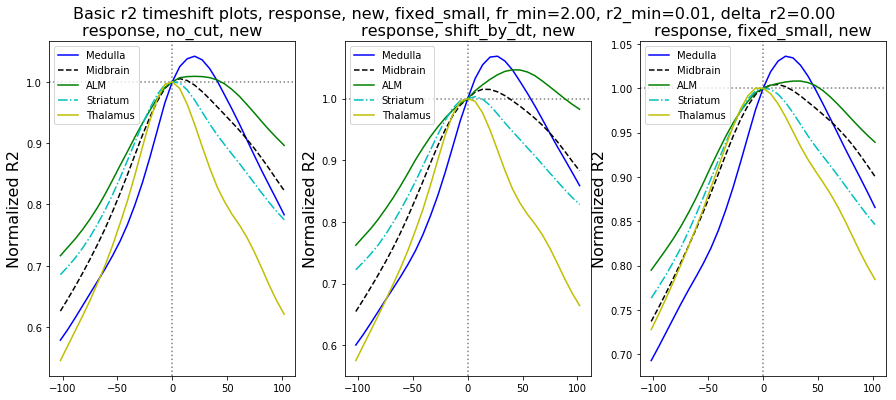

In [23]:

lines_colors = ['b-', 'k--', 'g-', 'c-.', 'y-']

r2_threshold = .01
fr_threshold = 2.
delta_r2 = 0.

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f, _ = plt.subplots(1,3, figsize = (15,6))
f.suptitle('Basic r2 timeshift plots, %s, %s, %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold,r2_threshold,delta_r2), fontsize = 16)


for itw, timewindow_cut in enumerate(timewindow_cuts):
    for ir2m, r2_method in enumerate(['new']):
        for iepoch, epoch in enumerate(['response']):

            r2 = []

            if itw < 2:
                fr = r2_new['5_0']['avg_fr'].copy()

                for timesh in timeshifts:
                    r2.append(r2_new['5_%d'%timesh]['%s_r2%s%s'%(epoch,twcuts_to_string[timewindow_cut],method_to_string[r2_method])].copy())

                r2= np.array(r2)
                r2[r2<0] = 0

                fr_inds = np.where(fr > fr_threshold)[0]
                threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
                threshold_inds = np.intersect1d(threshold_inds, fr_inds)


                
            elif itw == 2:
                fr = r2_smallwin['5_0']['avg_fr'].copy()

                for timesh in timeshifts:
                    r2.append(r2_smallwin['5_%d'%timesh]['%s_r2%s%s'%(epoch,twcuts_to_string[timewindow_cut],method_to_string[r2_method])].copy())

                r2= np.array(r2)
                r2[r2<0] = 0

                fr_inds = np.where(fr > fr_threshold)[0]
                threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
                threshold_inds = np.intersect1d(threshold_inds, fr_inds)
            
            plt.subplot(1,3,itw + 1)
            plt.title('%s, %s, %s'%(epoch,timewindow_cut,r2_method), fontsize = 16)
            for j, area in enumerate(areas):
                if area == 'ALM':
                    inds = alm_inds
                    if itw == 2:
                        inds = alm_inds_smallwin
                else:
                    inds = get_single_area_inds(area, df, ccf_labels)
                    if itw == 2:
                        inds = get_single_area_inds(area, df, ccf_labels_smallwin)

                inds = np.intersect1d(inds, threshold_inds)
                inds = np.intersect1d(inds, delta_inds)
                avg_r2 = r2[:,inds].mean(axis = 1)

                plt.plot(timeshifts*3.4, avg_r2/avg_r2[np.where(timeshifts == 0)[0][0]],lines_colors[j], label = area)



            a,b = plt.xlim()
            plt.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
            plt.xlim(a,b)

            a,b = plt.ylim()
            plt.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
            plt.ylim(a,b)

            if itw == 2 and ir2m == 1: plt.xlabel('Time shift (ms)', fontsize = 16)
            if iepoch == 0: plt.ylabel('Normalized R2', fontsize = 16)
            plt.legend()

plt.subplots_adjust(top = .90)
plt.savefig(figfolder + 'r2_timeshift_response_new_method_no_max_mean_filtered.pdf', bbox_inches = 'tight')

# Spatial maps

In [24]:
r2_threshold = .01
fr_threshold = 2.

epoch = 'response'
r2_method = 'new'
timewindow_cut = 'fixed_small'

fr = r2_smallwin['5_0']['avg_fr'].copy()
r2 = []

for timesh in timeshifts:
    r2.append(r2_smallwin['5_%d'%timesh]['%s_r2%s%s'%(epoch,twcuts_to_string[timewindow_cut],method_to_string[r2_method])].copy())

r2 = np.array(r2)
# there are no negative values in the new method
#r2[r2<0] = 0

fr_inds = np.where(fr > fr_threshold)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)

best_times = 3.4 * timeshifts[r2.argmax(axis = 0)]
area_colors = ['b', 'k', 'g', 'c', 'y']
k = 4

k_r2_diff = r2[np.where(timeshifts == k)[0][0],:] - r2[np.where(timeshifts == -k)[0][0],:]

area_inds = {}
for j, area in enumerate(areas):
    if area == 'ALM':
        inds = alm_inds_smallwin
    else:
        inds = get_single_area_inds(area, df, ccf_labels_smallwin)

    inds = np.intersect1d(inds, threshold_inds)
    area_inds[area] = inds

In [25]:
ccf_coords = r2_smallwin['5_0']['ccf_coords'].copy()
# center around bregma
ccf_coords[:,0] -= 5700
ccf_coords[:,2] -= 5400

In [26]:
plot_dict = dict()
plot_dict['xlim'] = (-4000, 4000)
plot_dict['ylim'] = (2000,7500)
plot_dict['zlim'] = (-2500,7500)
plot_dict['axis_zero_label'] = 'ML'
plot_dict['axis_one_label'] = 'DV'
plot_dict['axis_two_label'] = 'AP'

colorlim = (-50.,50)

area_colors = ['b', 'k', 'g', 'c', 'y']

In [27]:
delta_r2 = 1.25

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
fr_inds = np.where(fr > fr_threshold)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)

restricted_area_inds = {k:np.intersect1d(area_iii, delta_inds) for k,area_iii in area_inds.items()}

<ipython-input-27-8f6d26e6c3b3>:3: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


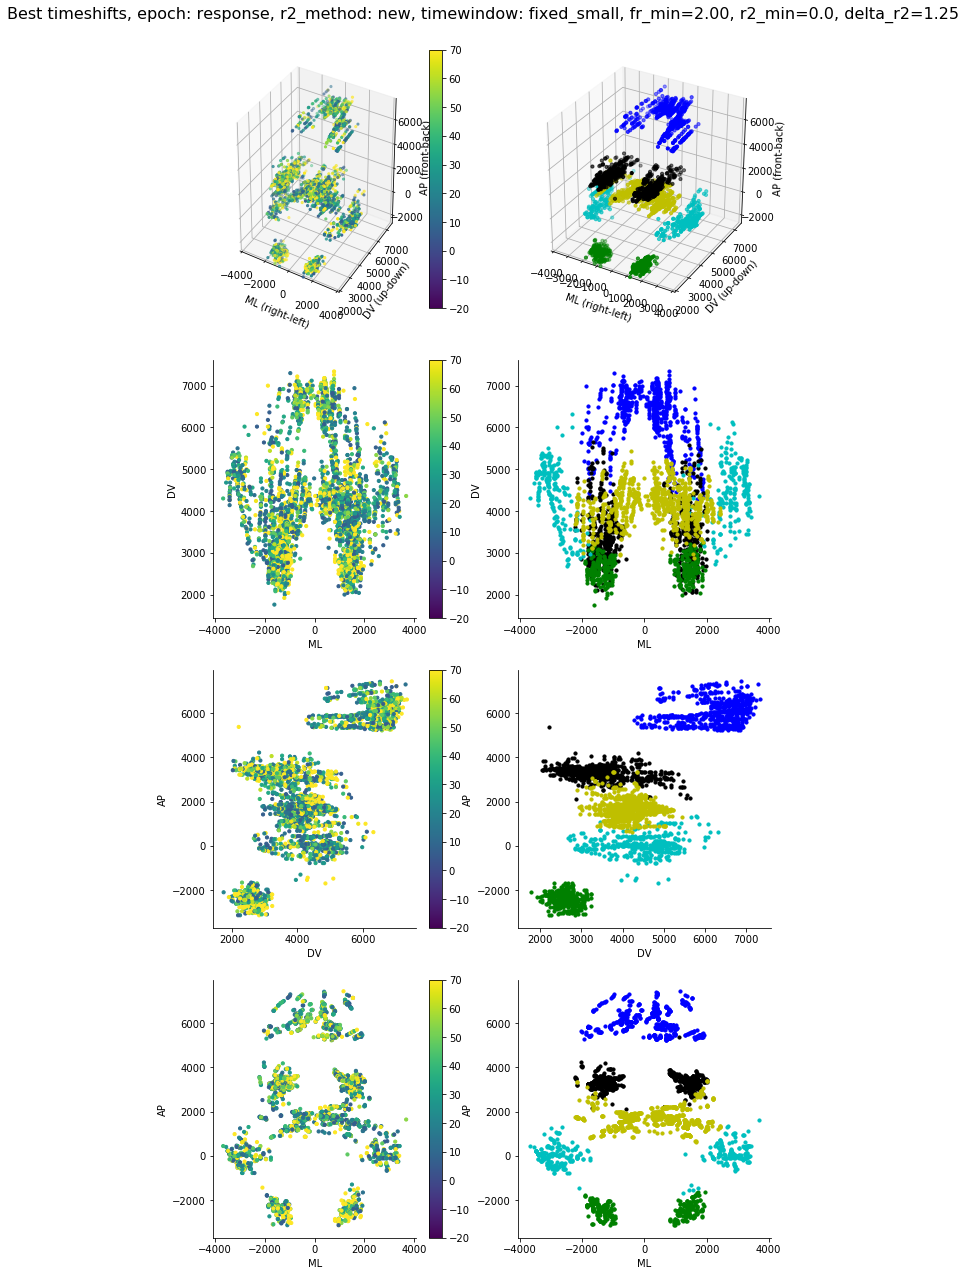

In [28]:

colorlim = (-20.,70)
f = plt.figure(figsize=(10,20))
f.suptitle('Best timeshifts, epoch: %s, r2_method: %s, timewindow: %s, fr_min=%.2f, r2_min=%.1f, delta_r2=%.2f'%(epoch,r2_method,timewindow_cut,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
ax = f.add_subplot(4,2,1, projection='3d')
ccf_analysis_utils.add_color_map_plot(ax, areas, restricted_area_inds, best_times , ccf_coords, \
                    0, colorlim, True, {**plot_dict, 'cmap':'viridis'})

ax = f.add_subplot(4,2,2, projection='3d')
ccf_analysis_utils.add_solid_color_plot(ax, areas, restricted_area_inds, best_times , \
                     ccf_coords, 0, \
                     area_colors, True, {**plot_dict})

ax = f.add_subplot(4,2,3)
three_d_flag = False
ccf_analysis_utils.add_color_map_plot(ax, areas, restricted_area_inds, best_times , ccf_coords[:,0:2], \
                    0, colorlim, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'DV','cmap':'viridis'})

ax = f.add_subplot(4,2,4)
ccf_analysis_utils.add_solid_color_plot(ax, areas, restricted_area_inds, best_times , \
                        ccf_coords[:,0:2], 0, \
                        area_colors, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'DV'})

ax = f.add_subplot(4,2,5)
ccf_analysis_utils.add_color_map_plot(ax, areas, restricted_area_inds, best_times , ccf_coords[:,1:], \
                    0, colorlim, three_d_flag, {**plot_dict,'xlabel':'DV', 'ylabel':'AP','cmap':'viridis'})

ax = f.add_subplot(4,2,6)
ccf_analysis_utils.add_solid_color_plot(ax, areas, restricted_area_inds, best_times , \
                     ccf_coords[:,1:], 0, \
                     area_colors, three_d_flag, {**plot_dict,'xlabel':'DV', 'ylabel':'AP'})

ax = f.add_subplot(4,2,7)
ccf_analysis_utils.add_color_map_plot(ax, areas, restricted_area_inds, best_times , ccf_coords[:,0::2], \
                    0, colorlim, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'AP','cmap':'viridis'})

ax = f.add_subplot(4,2,8)
ccf_analysis_utils.add_solid_color_plot(ax, areas, restricted_area_inds, best_times , \
                     ccf_coords[:,0::2], 0, \
                     area_colors, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'AP'})

plt.subplots_adjust(top=0.95)

plt.savefig(figfolder + 'max_over_avg_filtered_besttimes_spatial_map_frthreshold_%s_%s_%s.pdf'%(epoch,r2_method,timewindow_cut), bbox_inches='tight')

In [29]:
k = 20
k_r2_diff = r2[np.where(timeshifts == k)[0][0],:] - r2[np.where(timeshifts == -k)[0][0],:]

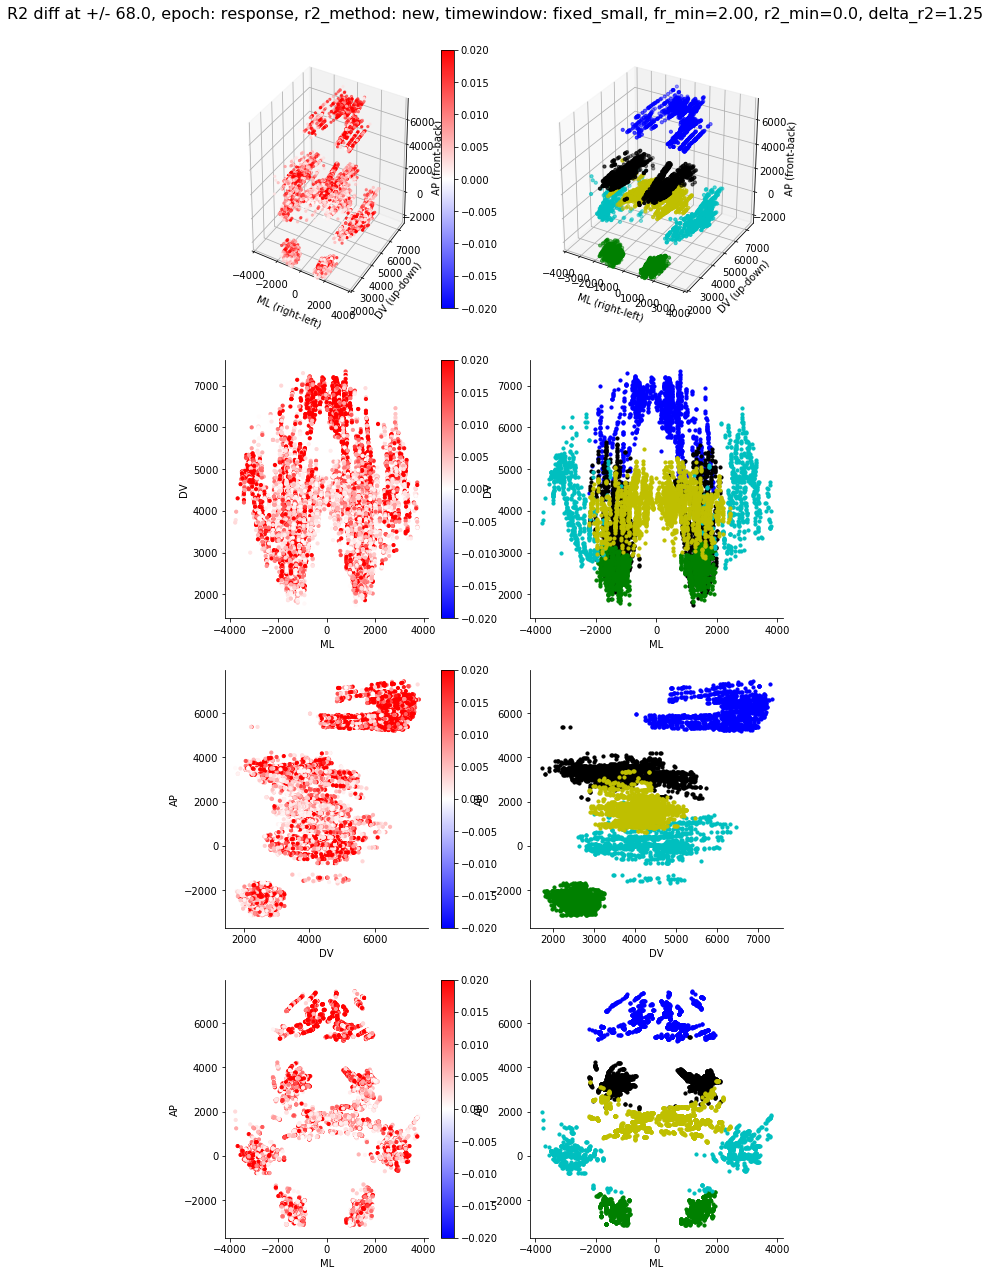

In [30]:
cmap = 'bwr'
colorlim = (-0.02,0.02)
f = plt.figure(figsize=(10,20))
f.suptitle('R2 diff at +/- %.1f, epoch: %s, r2_method: %s, timewindow: %s, fr_min=%.2f, r2_min=%.1f, delta_r2=%.2f'%(k*3.4,epoch,r2_method,timewindow_cut,fr_threshold,r2_threshold,delta_r2), fontsize = 16)

ax = f.add_subplot(4,2,1, projection='3d')
ccf_analysis_utils.add_color_map_plot(ax, areas, area_inds, k_r2_diff , ccf_coords, \
                    0, colorlim, True, {**plot_dict, 'cmap':cmap})

ax = f.add_subplot(4,2,2, projection='3d')
ccf_analysis_utils.add_solid_color_plot(ax, areas, area_inds, k_r2_diff , \
                     ccf_coords, 0, \
                     area_colors, True, {**plot_dict})

ax = f.add_subplot(4,2,3)
three_d_flag = False
ccf_analysis_utils.add_color_map_plot(ax, areas, area_inds, k_r2_diff , ccf_coords[:,0:2], \
                    0, colorlim, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'DV', 'cmap':cmap})

ax = f.add_subplot(4,2,4)
ccf_analysis_utils.add_solid_color_plot(ax, areas, area_inds, k_r2_diff , \
                        ccf_coords[:,0:2], 0, \
                        area_colors, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'DV', 'cmap':cmap})

ax = f.add_subplot(4,2,5)
ccf_analysis_utils.add_color_map_plot(ax, areas, area_inds, k_r2_diff , ccf_coords[:,1:], \
                    0, colorlim, three_d_flag, {**plot_dict,'xlabel':'DV', 'ylabel':'AP', 'cmap':cmap})

ax = f.add_subplot(4,2,6)
ccf_analysis_utils.add_solid_color_plot(ax, areas, area_inds, k_r2_diff , \
                     ccf_coords[:,1:], 0, \
                     area_colors, three_d_flag, {**plot_dict,'xlabel':'DV', 'ylabel':'AP', 'cmap':cmap})

ax = f.add_subplot(4,2,7)
ccf_analysis_utils.add_color_map_plot(ax, areas, area_inds, k_r2_diff , ccf_coords[:,0::2], \
                    0, colorlim, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'AP', 'cmap':cmap})

ax = f.add_subplot(4,2,8)
ccf_analysis_utils.add_solid_color_plot(ax, areas, area_inds, k_r2_diff , \
                     ccf_coords[:,0::2], 0, \
                     area_colors, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'AP', 'cmap':cmap})


plt.subplots_adjust(top=0.95)
plt.savefig(figfolder + 'max_over_avg_filtered_r2_diff_spatial_map_frthreshold_%s_%s_%s.pdf'%(epoch,r2_method,timewindow_cut), bbox_inches='tight')
plt.show()
plt.close()

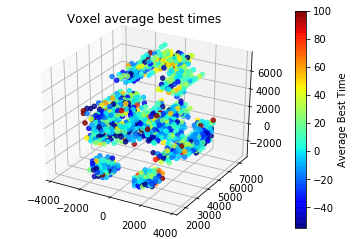

In [31]:
def average_best_times_in_voxels(best_times, ccf_coords, voxel_size):
    # Discretize each coordinate to a voxel
    voxel_indices = np.floor(ccf_coords / voxel_size).astype(int)
    
    # Create a dictionary to hold sum of best_times and count for averaging
    voxel_time_sum = {}
    voxel_count = {}
    
    for i, voxel_index in enumerate(voxel_indices):
        voxel_key = tuple(voxel_index)
        if voxel_key not in voxel_time_sum:
            voxel_time_sum[voxel_key] = best_times[i]
            voxel_count[voxel_key] = 1
        else:
            voxel_time_sum[voxel_key] += best_times[i]
            voxel_count[voxel_key] += 1
            
    # Calculate the average best_time for each voxel
    voxel_averages = {k: voxel_time_sum[k] / voxel_count[k] for k in voxel_time_sum}
    
    # Extract voxel centers and their corresponding averaged best_times
    voxel_centers = np.array(list(voxel_averages.keys())) * voxel_size + voxel_size / 2
    averaged_best_times = np.array(list(voxel_averages.values()))
    
    return voxel_centers, averaged_best_times

# Example usage
voxel_size = 300 # Define your voxel size
unified_area_inds = np.concatenate([v for v in area_inds.values()])

voxel_centers, averaged_best_times = average_best_times_in_voxels(best_times[unified_area_inds], ccf_coords[unified_area_inds], voxel_size)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Use the averaged best_times as color

scatter = ax.scatter(voxel_centers[:, 0], voxel_centers[:, 1], voxel_centers[:, 2], c=averaged_best_times, cmap='jet',vmin = -55,vmax = 100, alpha = 0.8,)
plt.colorbar(scatter, ax=ax, label='Average Best Time')
plt.title('Voxel average best times')
plt.show()

In [47]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0, 1), (1, 1, 1), (1, 1, 0), (1, 0, 0)]  # Blue -> White -> Yellow -> Red
positions = [-50, 0, 50, 100]

# Normalize positions to the range [0, 1]
norm_positions = [(pos - positions[0]) / (positions[-1] - positions[0]) for pos in positions]

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(norm_positions, colors)))


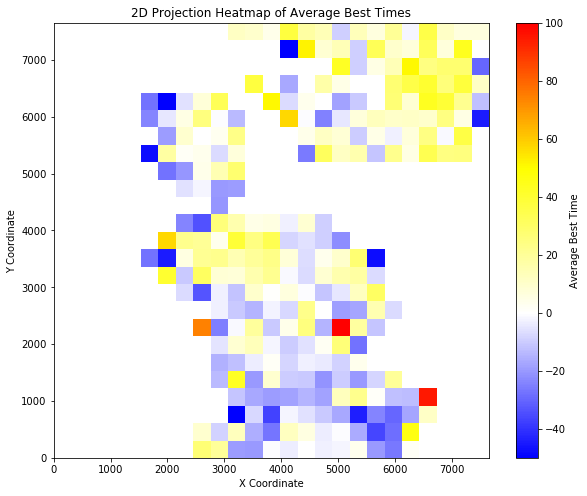

In [50]:


# Assuming voxel_centers, averaged_best_times, and grid_size are defined as before

# Choose the axis to project onto (0 for x, 1 for y, 2 for z)
# For this example, we'll project along the z-axis, aggregating values in the x-y plane
projection_axis = 0
xy_indices = np.delete(np.arange(3), projection_axis)

# Calculate the 2D grid dimensions
x_max, y_max = np.max(voxel_centers[:, xy_indices], axis=0) + voxel_size 
grid_shape_2d = (int(x_max / voxel_size ), int(y_max / voxel_size ))

# Initialize a 2D grid to hold the summed best_time values and a count for averaging
sum_grid = np.zeros(grid_shape_2d)
count_grid = np.zeros(grid_shape_2d, dtype=int)

# Populate the grids
for center, time in zip(voxel_centers, averaged_best_times):
    x, y = (center[xy_indices] / voxel_size ).astype(int)
    sum_grid[x, y] += time
    count_grid[x, y] += 1

# Avoid division by zero for voxels with no data
with np.errstate(divide='ignore', invalid='ignore'):
    average_grid = np.true_divide(sum_grid, count_grid)
    average_grid[~np.isfinite(average_grid)] = 0  # Replace NaNs and infs with 0

# Plotting the 2D heatmap
plt.figure(figsize=(10, 8))
plt.imshow(average_grid.T, origin='lower', extent=[0, x_max, 0, y_max], cmap=custom_cmap, vmin = -50,vmax = 100)
plt.colorbar(label='Average Best Time')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('2D Projection Heatmap of Average Best Times')
plt.show()


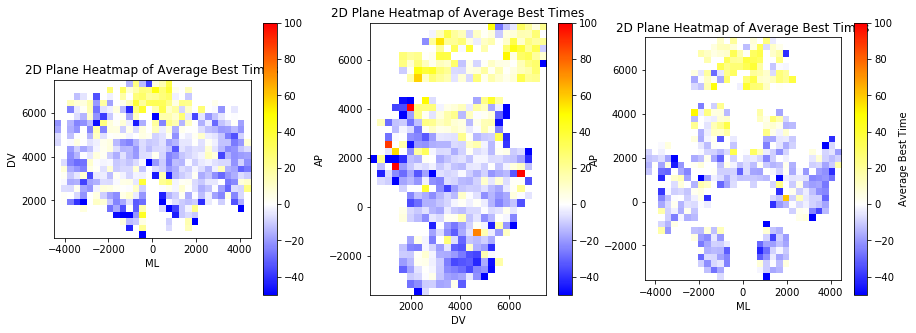

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the following variables:
# best_times = np.array([...]) # An array of best times
# ccf_coords = np.array([...]) # An array of 3D coordinates

plt.subplots(1,3, figsize = (15,5))

# Define voxel size for the 2D plane
voxel_size = 300

# Project ccf_coords onto the 2D plane (e.g., ignoring the z-coordinate)
coords_2d = ccf_coords[:, :2]  # Assuming the first two columns are x and y
# ML, DW, AP

# Calculate the voxel indices for each point
voxel_indices = np.floor(coords_2d / voxel_size).astype(int)

# Find the bounds for the grid
min_indices = np.min(voxel_indices, axis=0)
max_indices = np.max(voxel_indices, axis=0)
grid_shape = max_indices - min_indices + 1

# Initialize a grid to store the sum and count of best_times for averaging
sum_grid = np.zeros(grid_shape)
count_grid = np.zeros(grid_shape)

# Populate the grids with summed times and counts
for index, time in zip(voxel_indices, best_times):
    normalized_index = tuple(index - min_indices)  # Normalize indices to start from 0,0
    sum_grid[normalized_index] += time
    count_grid[normalized_index] += 1

# Calculate the average best time for each voxel
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    avg_grid = np.divide(sum_grid, count_grid)
    avg_grid[np.isnan(avg_grid)] = 0  # Replace NaNs with 0

# Plotting the 2D heatmap
plt.subplot(1,3,1)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('2D Plane Heatmap of Average Best Times')


coords_2d = ccf_coords[:,1:]  # Assuming the first two columns are x and y
# ML, Dv, AP

# Calculate the voxel indices for each point
voxel_indices = np.floor(coords_2d / voxel_size).astype(int)

# Find the bounds for the grid
min_indices = np.min(voxel_indices, axis=0)
max_indices = np.max(voxel_indices, axis=0)
grid_shape = max_indices - min_indices + 1

# Initialize a grid to store the sum and count of best_times for averaging
sum_grid = np.zeros(grid_shape)
count_grid = np.zeros(grid_shape)

# Populate the grids with summed times and counts
for index, time in zip(voxel_indices, best_times):
    normalized_index = tuple(index - min_indices)  # Normalize indices to start from 0,0
    sum_grid[normalized_index] += time
    count_grid[normalized_index] += 1

# Calculate the average best time for each voxel
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    avg_grid = np.divide(sum_grid, count_grid)
    avg_grid[np.isnan(avg_grid)] = 0  # Replace NaNs with 0

# Plotting the 2D heatmap
plt.subplot(1,3,2)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('2D Plane Heatmap of Average Best Times')



coords_2d = ccf_coords[:, ::2]  # Assuming the first two columns are x and y
# ML, DW, AP

# Calculate the voxel indices for each point
voxel_indices = np.floor(coords_2d / voxel_size).astype(int)

# Find the bounds for the grid
min_indices = np.min(voxel_indices, axis=0)
max_indices = np.max(voxel_indices, axis=0)
grid_shape = max_indices - min_indices + 1

# Initialize a grid to store the sum and count of best_times for averaging
sum_grid = np.zeros(grid_shape)
count_grid = np.zeros(grid_shape)

# Populate the grids with summed times and counts
for index, time in zip(voxel_indices, best_times):
    normalized_index = tuple(index - min_indices)  # Normalize indices to start from 0,0
    sum_grid[normalized_index] += time
    count_grid[normalized_index] += 1

# Calculate the average best time for each voxel
with np.errstate(invalid='ignore'):  # Ignore divisions by 0
    avg_grid = np.divide(sum_grid, count_grid)
    avg_grid[np.isnan(avg_grid)] = 0  # Replace NaNs with 0

# Plotting the 2D heatmap
plt.subplot(1,3,3)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar(label='Average Best Time')
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('2D Plane Heatmap of Average Best Times')
plt.show()



In [59]:
def get_2D_grid_averages(best_times, ccf_coords, voxel_size, projection_axis = 0):
    # Project ccf_coords onto the 2D plane
    coords_2d = np.delete(ccf_coords, projection_axis, axis=1)
    
    # Calculate the voxel indices for each point
    voxel_indices = np.floor(coords_2d / voxel_size).astype(int)
    
    # Find the bounds for the grid
    min_indices = np.min(voxel_indices, axis=0)
    max_indices = np.max(voxel_indices, axis=0)
    grid_shape = max_indices - min_indices + 1
    
    # Initialize a grid to store the sum and count of best_times for averaging
    sum_grid = np.zeros(grid_shape)
    count_grid = np.zeros(grid_shape)
    
    # Populate the grids with summed times and counts
    for index, time in zip(voxel_indices, best_times):
        normalized_index = tuple(index - min_indices)  # Normalize indices to start from 0,0
        sum_grid[normalized_index] += time
        count_grid[normalized_index] += 1
    
    # Calculate the average best time for each voxel
    with np.errstate(invalid='ignore'):  # Ignore divisions by 0
        avg_grid = np.divide(sum_grid, count_grid)
        avg_grid[np.isnan(avg_grid)] = 0  # Replace NaNs with 0
    
    return avg_grid, min_indices, max_indices

In [64]:
delta_r2 = 1.25

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
fr_inds = np.where(fr > fr_threshold)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)

restriction_inds = np.intersect1d(threshold_inds, delta_inds)

<ipython-input-64-f649c883d629>:3: RuntimeWarning: invalid value encountered in true_divide
  delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]


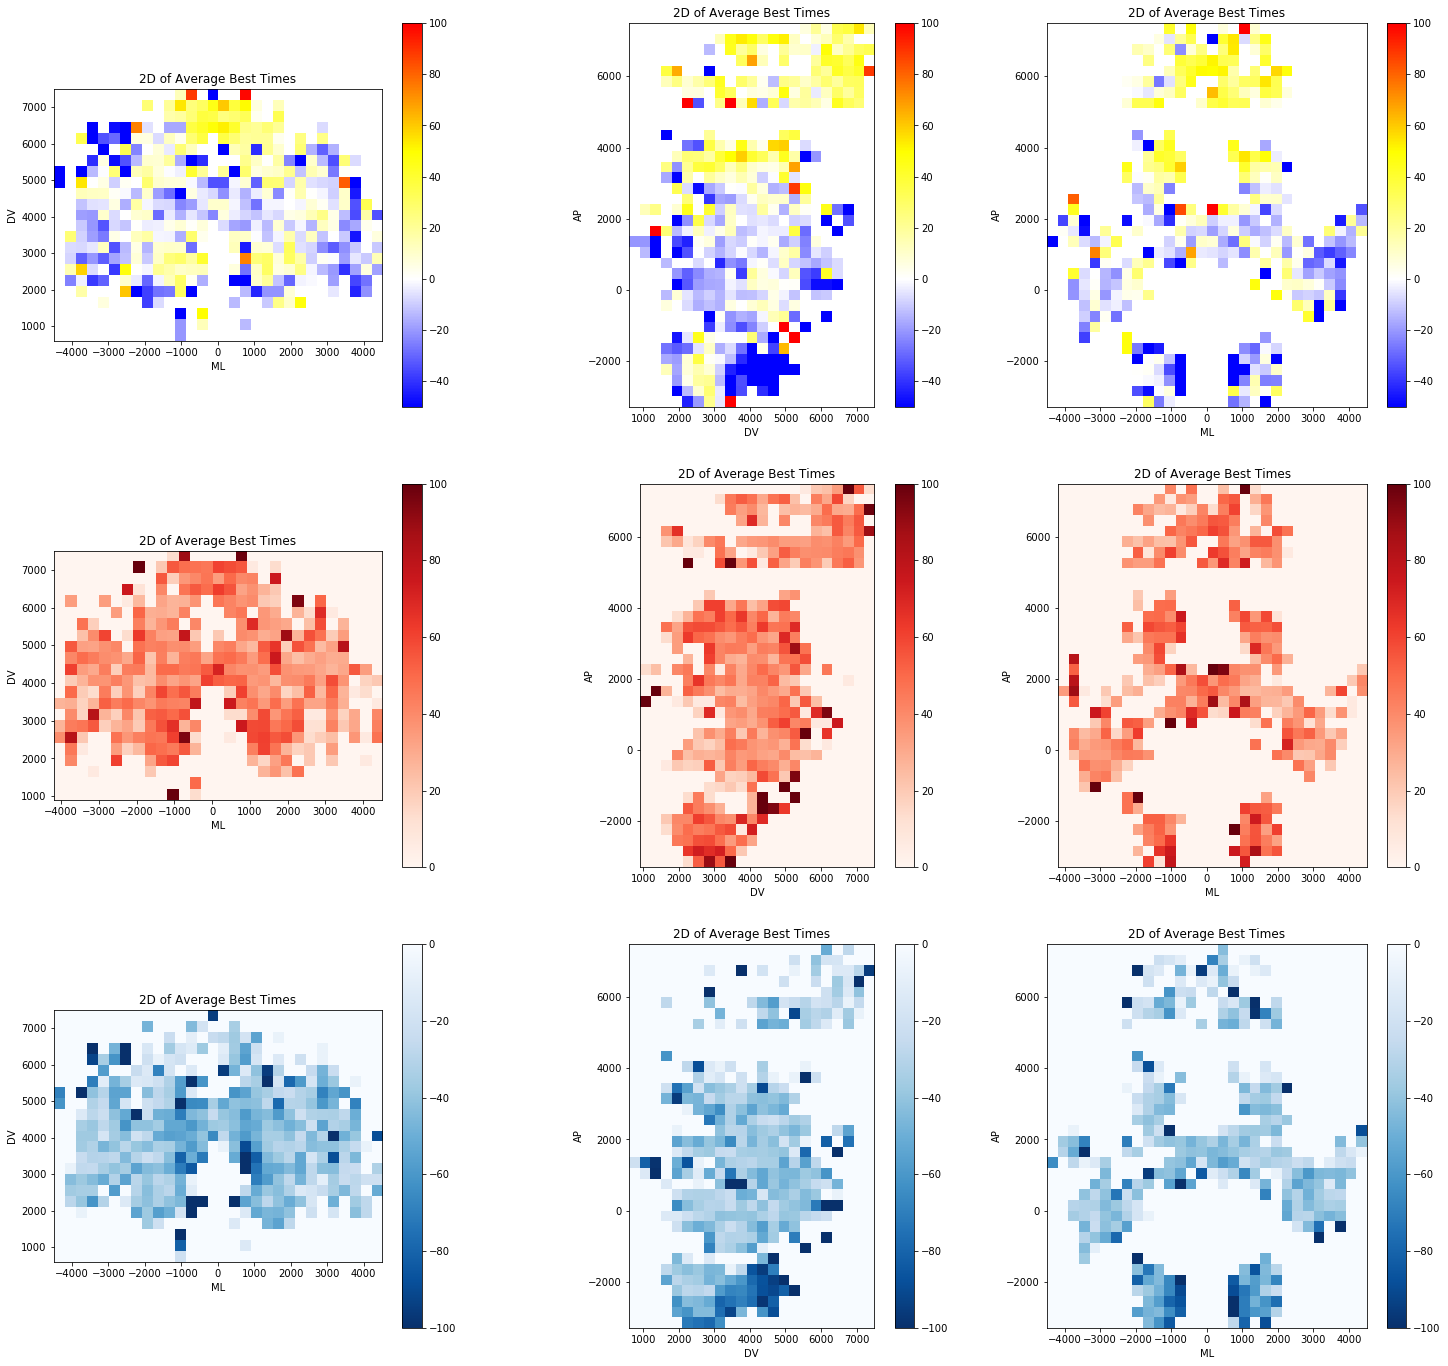

In [73]:
plt.subplots(3,3, figsize = (25,24))



# Define voxel size for the 2D plane
voxel_size = 300
avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 2)


plt.subplot(3,3,1)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('2D of Average Best Times')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 0)


plt.subplot(3,3,2)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds], ccf_coords[restriction_inds], voxel_size, projection_axis = 1)


plt.subplot(3,3,3)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap=custom_cmap, vmin = -50,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

pos_inds = np.where(best_times[restriction_inds] > 0)[0]

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds][pos_inds], ccf_coords[restriction_inds][pos_inds], voxel_size, projection_axis = 2)


plt.subplot(3,3,4)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Reds', vmin = 0,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('2D of Average Best Times')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds][pos_inds], ccf_coords[restriction_inds][pos_inds], voxel_size, projection_axis = 0)


plt.subplot(3,3,5)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Reds', vmin = 0,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds][pos_inds], ccf_coords[restriction_inds][pos_inds], voxel_size, projection_axis = 1)


plt.subplot(3,3,6)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Reds', vmin = 0,vmax = 100, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

neg_inds = np.where(best_times[restriction_inds] < 0)[0]
avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds][neg_inds], ccf_coords[restriction_inds][neg_inds], voxel_size, projection_axis = 2)


plt.subplot(3,3,7)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Blues_r', vmin = -100,vmax = 0, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('DV')
plt.title('2D of Average Best Times')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds][neg_inds], ccf_coords[restriction_inds][neg_inds], voxel_size, projection_axis = 0)


plt.subplot(3,3,8)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Blues_r', vmin = -100,vmax = 0, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('DV')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

avg_grid, min_indices, max_indices = get_2D_grid_averages(best_times[restriction_inds][neg_inds], ccf_coords[restriction_inds][neg_inds], voxel_size, projection_axis = 1)


plt.subplot(3,3,9)
plt.imshow(avg_grid.T,origin='lower', interpolation='nearest',cmap='Blues_r', vmin = -100,vmax = 0, extent=[min_indices[0]*voxel_size, (max_indices[0]+1)*voxel_size, min_indices[1]*voxel_size, (max_indices[1]+1)*voxel_size])
plt.colorbar()
plt.xlabel('ML')
plt.ylabel('AP')
plt.title('2D of Average Best Times')

plt.savefig(figfolder + '2D_of_Average_Best_Times.pdf', bbox_inches='tight')


In [74]:
len(pos_inds), len(neg_inds), len(pos_inds) + len(neg_inds), len(restriction_inds)

(3793, 3730, 7523, 7971)